#**An Autonomous Traffic Light Control System Using Q-Learning**

Problem Description An autonomous traffic light system is responsible for controlling the duration of green and red signals at a busy intersection to minimize vehicle congestion and maximize traffic flow. The traffic light must learn to adapt dynamically to changing traffic patterns.

Key Components of the Problem

Intersection Layout

A four-way intersection with traffic coming from North (N), East (E), South (S), and West (W).
At any point in time, only two directions (e.g., N-S or E-W) can have a green light.

**State Space**

The system observes the queue length of vehicles at each direction:
𝑠=[𝑄_𝑁,𝑄_𝐸,𝑄_𝑆,𝑄_𝑊] where 𝑄_𝑁,𝑄_𝐸,𝑄_𝑆,𝑄_𝑊 are the number of vehicles waiting at the respective directions, discretized into bins (e.g., 0-5, 6-10, >10).

**Action Space**

The agent controls the traffic light, choosing from:
Green for N-S, red for E-W.
Green for E-W, red for N-S.

All red (e.g., for pedestrian crossing or to clear intersections briefly).

**Reward System**

Rewards are designed to minimize vehicle wait times:
−1 for each vehicle waiting in a queue.
−5penalty for vehicles waiting longer than a threshold (e.g., 10 seconds).
Positive reward for reducing queue lengths in the next state.

**Environment Dynamics**

Vehicles arrive at random rates (e.g., Poisson distribution) based on real-world traffic patterns.
The agent learns how long to keep lights green or red in response to changing traffic.
Goal
Minimize average wait times and congestion at the intersection.

Episode 0, Total Reward: -162, Epsilon: 0.9950
Episode 100, Total Reward: -293, Epsilon: 0.6027
Episode 200, Total Reward: -162, Epsilon: 0.3651
Episode 300, Total Reward: -137, Epsilon: 0.2212
Episode 400, Total Reward: -294, Epsilon: 0.1340
Episode 500, Total Reward: -202, Epsilon: 0.0812
Episode 600, Total Reward: -433, Epsilon: 0.0492
Episode 700, Total Reward: -149, Epsilon: 0.0298
Episode 800, Total Reward: -415, Epsilon: 0.0180
Episode 900, Total Reward: -307, Epsilon: 0.0109
Episode 1000, Total Reward: -258, Epsilon: 0.0066
Episode 1100, Total Reward: -257, Epsilon: 0.0040
Episode 1200, Total Reward: -104, Epsilon: 0.0024
Episode 1300, Total Reward: -168, Epsilon: 0.0015
Episode 1400, Total Reward: -263, Epsilon: 0.0009
Episode 1500, Total Reward: -328, Epsilon: 0.0005
Episode 1600, Total Reward: -241, Epsilon: 0.0003
Episode 1700, Total Reward: -99, Epsilon: 0.0002
Episode 1800, Total Reward: -467, Epsilon: 0.0001
Episode 1900, Total Reward: -170, Epsilon: 0.0001


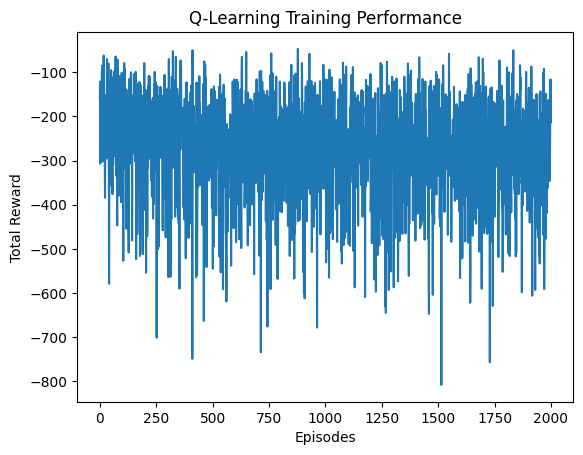

In [1]:
#Required libraries
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation
from IPython.display import HTML
import random
from IPython import get_ipython
from IPython.display import display, HTML
from matplotlib.animation import FuncAnimation
import random

class TrafficLightEnv:
    def __init__(self):
        self.max_queue = 20  # Maximum vehicles in a queue
        self.state = np.zeros(4, dtype=int)  # Initial queue lengths
        self.time_step = 1  # Time step in seconds
        self.green_duration = 5  # Minimum green duration

        # Action space: 0 -> Green N-S, 1 -> Green E-W, 2 -> All red
        self.action_space = [0, 1, 2]

    def step(self, action):
        arrivals = np.random.poisson(3, 4)  # Random arrivals for N, E, S, W

        if action == 0:  # Green for N-S
            self.state[0] = max(0, self.state[0] - random.randint(3, 7))  # Reduce N queue
            self.state[2] = max(0, self.state[2] - random.randint(3, 7))  # Reduce S queue
        elif action == 1:  # Green for E-W
            self.state[1] = max(0, self.state[1] - random.randint(3, 7))  # Reduce E queue
            self.state[3] = max(0, self.state[3] - random.randint(3, 7))  # Reduce W queue

        # Add new arrivals
        self.state += arrivals
        self.state = np.clip(self.state, 0, self.max_queue)  # Ensure within limits

        # Reward: Negative for long queues, positive for reducing congestion
        reward = -sum(self.state) + 10 if action in [0, 1] else -sum(self.state)

        # Check if queues exceed maximum threshold
        done = np.any(self.state >= self.max_queue)

        return self.state, reward, done

    def reset(self):
        self.state = np.random.randint(0, 10, 4)  # Random initial queues
        return self.state

class QLearningAgent:
    def __init__(self, state_bins=10, actions=3, alpha=0.1, gamma=0.95, epsilon=1.0, epsilon_decay=0.995):
        self.state_bins = state_bins
        self.actions = actions
        self.alpha = alpha
        self.gamma = gamma
        self.epsilon = epsilon
        self.epsilon_decay = epsilon_decay
        self.q_table = np.zeros((state_bins, state_bins, state_bins, state_bins, actions))

    def discretize_state(self, state):
        # Clip state values to be within the bounds of the bins
        clipped_state = np.clip(state, 0, (20 / self.state_bins) * self.state_bins - 1)
        return tuple((clipped_state / (20 / self.state_bins)).astype(int))

    def choose_action(self, state):
        if np.random.rand() < self.epsilon:
            return np.random.choice(self.actions)  # Explore
        discrete_state = self.discretize_state(state)
        return np.argmax(self.q_table[discrete_state])  # Exploit

    def update_q_value(self, state, action, reward, next_state):
        discrete_state = self.discretize_state(state)
        discrete_next_state = self.discretize_state(next_state)
        best_next_action = np.max(self.q_table[discrete_next_state])
        self.q_table[discrete_state][action] += self.alpha * (reward + self.gamma * best_next_action - self.q_table[discrete_state][action])

# Initialize environment and agent
env = TrafficLightEnv()
agent = QLearningAgent()

# Training loop
episodes = 2000
rewards = []

for episode in range(episodes):
    state = env.reset()
    done = False
    total_reward = 0

    while not done:
        action = agent.choose_action(state)
        next_state, reward, done = env.step(action)
        agent.update_q_value(state, action, reward, next_state)
        state = next_state
        total_reward += reward

    agent.epsilon *= agent.epsilon_decay  # Decay epsilon
    rewards.append(total_reward)

    if episode % 100 == 0:
        print(f"Episode {episode}, Total Reward: {total_reward}, Epsilon: {agent.epsilon:.4f}")

# Plot training rewards
plt.plot(rewards)
plt.xlabel("Episodes")
plt.ylabel("Total Reward")
plt.title("Q-Learning Training Performance")
plt.show()

Episode 0, Total Reward: -172, Epsilon: 0.9950
Episode 100, Total Reward: -263, Epsilon: 0.6027
Episode 200, Total Reward: -297, Epsilon: 0.3651
Episode 300, Total Reward: -282, Epsilon: 0.2212
Episode 400, Total Reward: -432, Epsilon: 0.1340
Episode 500, Total Reward: -398, Epsilon: 0.0812
Episode 600, Total Reward: -486, Epsilon: 0.0492
Episode 700, Total Reward: -225, Epsilon: 0.0298
Episode 800, Total Reward: -262, Epsilon: 0.0180
Episode 900, Total Reward: -155, Epsilon: 0.0109
Episode 1000, Total Reward: -381, Epsilon: 0.0066
Episode 1100, Total Reward: -110, Epsilon: 0.0040
Episode 1200, Total Reward: -264, Epsilon: 0.0024
Episode 1300, Total Reward: -465, Epsilon: 0.0015
Episode 1400, Total Reward: -194, Epsilon: 0.0009
Episode 1500, Total Reward: -350, Epsilon: 0.0005
Episode 1600, Total Reward: -209, Epsilon: 0.0003
Episode 1700, Total Reward: -227, Epsilon: 0.0002
Episode 1800, Total Reward: -278, Epsilon: 0.0001
Episode 1900, Total Reward: -226, Epsilon: 0.0001


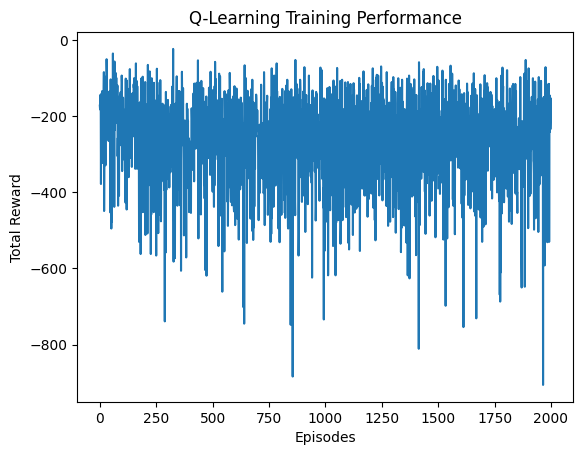

In [4]:

# Environment class
class TrafficLightEnv:
    def __init__(self):
        self.max_queue = 20
        self.state = np.zeros(4, dtype=int)  # N, E, S, W
        self.time_step = 1
        self.green_duration = 5
        self.action_space = [0, 1, 2]

    def step(self, action):
        arrivals = np.random.poisson(3, 4)

        if action == 0:
            self.state[0] = max(0, self.state[0] - random.randint(3, 7))
            self.state[2] = max(0, self.state[2] - random.randint(3, 7))
        elif action == 1:
            self.state[1] = max(0, self.state[1] - random.randint(3, 7))
            self.state[3] = max(0, self.state[3] - random.randint(3, 7))

        self.state += arrivals
        self.state = np.clip(self.state, 0, self.max_queue)

        reward = -sum(self.state) + 10 if action in [0, 1] else -sum(self.state)
        done = np.any(self.state >= self.max_queue)

        return self.state, reward, done

    def reset(self):
        self.state = np.random.randint(0, 10, 4)
        return self.state

# Q-learning agent
class QLearningAgent:
    def __init__(self, state_bins=10, actions=3, alpha=0.1, gamma=0.95, epsilon=1.0, epsilon_decay=0.995):
        self.state_bins = state_bins
        self.actions = actions
        self.alpha = alpha
        self.gamma = gamma
        self.epsilon = epsilon
        self.epsilon_decay = epsilon_decay
        self.q_table = np.zeros((state_bins, state_bins, state_bins, state_bins, actions))

    def discretize_state(self, state):
        clipped_state = np.clip(state, 0, (20 / self.state_bins) * self.state_bins - 1)
        return tuple((clipped_state / (20 / self.state_bins)).astype(int))

    def choose_action(self, state):
        if np.random.rand() < self.epsilon:
            return np.random.choice(self.actions)
        discrete_state = self.discretize_state(state)
        return np.argmax(self.q_table[discrete_state])

    def update_q_value(self, state, action, reward, next_state):
        discrete_state = self.discretize_state(state)
        discrete_next_state = self.discretize_state(next_state)
        best_next_action = np.max(self.q_table[discrete_next_state])
        self.q_table[discrete_state][action] += self.alpha * (reward + self.gamma * best_next_action - self.q_table[discrete_state][action])

# Initialize
env = TrafficLightEnv()
agent = QLearningAgent()
episodes = 2000
rewards = []

# Training
for episode in range(episodes):
    state = env.reset()
    done = False
    total_reward = 0

    while not done:
        action = agent.choose_action(state)
        next_state, reward, done = env.step(action)
        agent.update_q_value(state, action, reward, next_state)
        state = next_state
        total_reward += reward

    agent.epsilon *= agent.epsilon_decay
    rewards.append(total_reward)

    if episode % 100 == 0:
        print(f"Episode {episode}, Total Reward: {total_reward}, Epsilon: {agent.epsilon:.4f}")

# Plot training rewards
plt.plot(rewards)
plt.xlabel("Episodes")
plt.ylabel("Total Reward")
plt.title("Q-Learning Training Performance")
plt.show()

# === Visualization Section ===
# Real-time intersection simulation
state = env.reset()
frames = []
actions = []
rewards_over_time = []
time_steps = 100

for _ in range(time_steps):
    action = agent.choose_action(state)
    next_state, reward, done = env.step(action)
    frames.append(state.copy())
    actions.append(action)
    rewards_over_time.append(reward)
    state = next_state

# Set up the plot
fig, ax = plt.subplots(figsize=(6, 4))
bars = ax.bar(['N', 'E', 'S', 'W'], frames[0], color='skyblue')
title = ax.set_title("")

def update(frame):
    heights = frames[frame]
    action = actions[frame]
    for bar, h in zip(bars, heights):
        bar.set_height(h)
    colors = ['lightgreen' if action == 0 and i in [0, 2] else
              'lightgreen' if action == 1 and i in [1, 3] else
              'tomato' for i in range(4)]
    for i, bar in enumerate(bars):
        bar.set_color(colors[i])
    title.set_text(f"Step {frame}, Action: {['NS-Green','EW-Green','All-Red'][action]}, Queues: {list(heights)}")

ani = FuncAnimation(fig, update, frames=len(frames), repeat=False)
plt.close()  # Hide static plot

# Display animation in Jupyter
display(HTML(ani.to_jshtml()))

